# P3 - Movie Genre Classification - Neural Network

Elaborado por GRUPO 1:

- Juanita Piraban Barbosa - 201216313
- Lorena Morales Rodríguez - 202027957
- Alejandro Barinas Guio - 201628859
- Jaime Humberto Trujillo Perea - 201920366
- Alexander Zapata Galindo - 201425426

### Objective

Classify a movie genre based on its plot.
Source: https://www.kaggle.com/c/miia4201-202019-p3-moviegenreclassification/overview

- Input: movie plot
- Output: Probability of the movie belong to each genre

### Evaluation

- 50% Report with all the details of the solution, the analysis and the conclusions. The report cannot exceed 10 pages, must be send in PDF format and must be self-contained.
- 50% Performance in the Kaggle competition (The grade for each group will be proportional to the ranking it occupies in the competition. The group in the first place will obtain 5 points, for each position below, 0.25 points will be subtracted, that is: first place: 5 points, second: 4.75 points, third place: 4.50 points ... eleventh place: 2.50 points, twelfth place: 2.25 points).

### Deatline

- The project must be carried out in the groups assigned.
- Use clear and rigorous procedures.
- The delivery of the project is on August 1st, 2021, 11:59 pm, through Bloque Neón.
- No projects will be received after the delivery time or by any other means than the one established.

### Acknowledgements

We thank Professor Fabio Gonzalez, Ph.D. and his student John Arevalo for providing this dataset.
See https://arxiv.org/abs/1702.01992

## Sample Submission

In [64]:
# Librerías

import pandas as pd
from matplotlib import pyplot as plt
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

import keras
from keras import backend as K

import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

#pip install livelossplot
from livelossplot import PlotLossesKeras
%matplotlib inline

import nltk
from nltk.corpus import stopwords

from xgboost import XGBClassifier
import re

import warnings
warnings.filterwarnings('ignore')

In [65]:
df_train = pd.read_csv('dataTraining.csv', encoding='UTF-8', index_col=0)
df_test = pd.read_csv('dataTesting.csv', encoding='UTF-8', index_col=0)

In [66]:
df_train.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [67]:
df_train['rating'] = df_train['rating'].astype(int)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7895 entries, 3107 to 215
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    7895 non-null   int64 
 1   title   7895 non-null   object
 2   plot    7895 non-null   object
 3   genres  7895 non-null   object
 4   rating  7895 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 370.1+ KB


In [68]:
df_test.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


In [69]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3383 entries, 1 to 11275
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    3383 non-null   int64 
 1   title   3383 non-null   object
 2   plot    3383 non-null   object
dtypes: int64(1), object(2)
memory usage: 105.7+ KB


### Create y

In [70]:
df_train['genres'] = df_train['genres'].map(lambda x: eval(x))

le = MultiLabelBinarizer()
y = le.fit_transform(df_train['genres'])
y.shape

(7895, 24)

In [71]:
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])

### Vocabulary

In [73]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
#nltk.download('wordnet')
#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

In [74]:
X= pd.DataFrame(df_train['plot'])
X1= pd.DataFrame(df_test['plot'])

spec_chars = ['!', '"', '$', '%', '&', "'", '(', ')', ',', '-', '.', '/', ':', ';', '?','£', 'è']
for char in spec_chars:
    X = X.apply(lambda x: x.str.replace(char, ''))
    X1 = X1.apply(lambda x: x.str.replace(char, ''))

X= X['plot']
X1= X1['plot']

In [76]:
# define a function that accepts text and returns a list of lemmas
def split_into_lemmas(text):
    porter = PorterStemmer()
    text = text.lower()
    words = text.split()
    words = [w for w in words if not w in stop_words]
    words = [porter.stem(word) for word in words]
    words = [w for w in words if not w in stop_words]
    return [wordnet_lemmatizer.lemmatize(word) for word in words]

In [77]:
# Lemmatization
vect = CountVectorizer(stop_words='english', max_features=9000, analyzer=split_into_lemmas)
X_dtm = vect.fit_transform(X)
voc = vect.get_feature_names()

X_pad=X_dtm.toarray()
X_pad

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [78]:
##Vocabulario
vocabulary = {x: idx + 1 for idx, x in enumerate(set(voc))}
print(sorted(vocabulary))
len(vocabulary)

['aa', 'aaron', 'abandon', 'abbey', 'abbi', 'abbott', 'abduct', 'abe', 'abel', 'abigail', 'abil', 'abl', 'abner', 'aboard', 'abort', 'abound', 'abraham', 'abroad', 'abruptli', 'abscond', 'absenc', 'absent', 'absolut', 'absorb', 'absurd', 'abu', 'abus', 'abyss', 'academ', 'academi', 'accept', 'access', 'accessori', 'accid', 'accident', 'acclaim', 'accommod', 'accompani', 'accomplic', 'accomplish', 'accord', 'account', 'accur', 'accus', 'accustom', 'ace', 'acerb', 'achiev', 'acid', 'acknowledg', 'acquaint', 'acquir', 'acr', 'acrobat', 'across', 'act', 'action', 'activ', 'activist', 'actor', 'actress', 'actual', 'ad', 'ada', 'adam', 'adapt', 'add', 'addi', 'addict', 'addit', 'address', 'adel', 'adelaid', 'adept', 'adequ', 'adher', 'adjust', 'adm', 'administ', 'administr', 'admir', 'admiss', 'admit', 'adolesc', 'adolf', 'adopt', 'ador', 'adrian', 'adrien', 'adrienn', 'adrift', 'adult', 'adulthood', 'advanc', 'advantag', 'adventur', 'adversari', 'advertis', 'advic', 'advis', 'advisor', 'adv

9000

### Train / Test

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.25, random_state=42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(5921, 9000) (5921, 24)
(1974, 9000) (1974, 24)


In [84]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [85]:
X_test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [86]:
y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [87]:
y_test

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

### Model

In [88]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from keras import layers
import keras.optimizers as opts
from keras import backend as K
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from livelossplot import PlotLossesKeras
#from keras.optimizers import SGD
from keras.layers import GaussianNoise
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

In [93]:
# Model
K.clear_session()
model = Sequential()
model.add(layers.Embedding(input_dim=len(vocabulary) + 1, output_dim=6,   input_length=X_train.shape[1]))  
model.add(layers.Flatten())
model.add(Dropout(0.1))
model.add(layers.Dense(400,activation='sigmoid')) 
model.add(GaussianNoise(0.1))
model.add(layers.Dense(24, activation='sigmoid'))
metric = tf.keras.metrics.AUC(multi_label = True)
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=[metric]) 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 9000, 6)           54006     
_________________________________________________________________
flatten (Flatten)            (None, 54000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 54000)             0         
_________________________________________________________________
dense (Dense)                (None, 400)               21600400  
_________________________________________________________________
gaussian_noise (GaussianNois (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                9624      
Total params: 21,664,030
Trainable params: 21,664,030
Non-trainable params: 0
____________________________________________

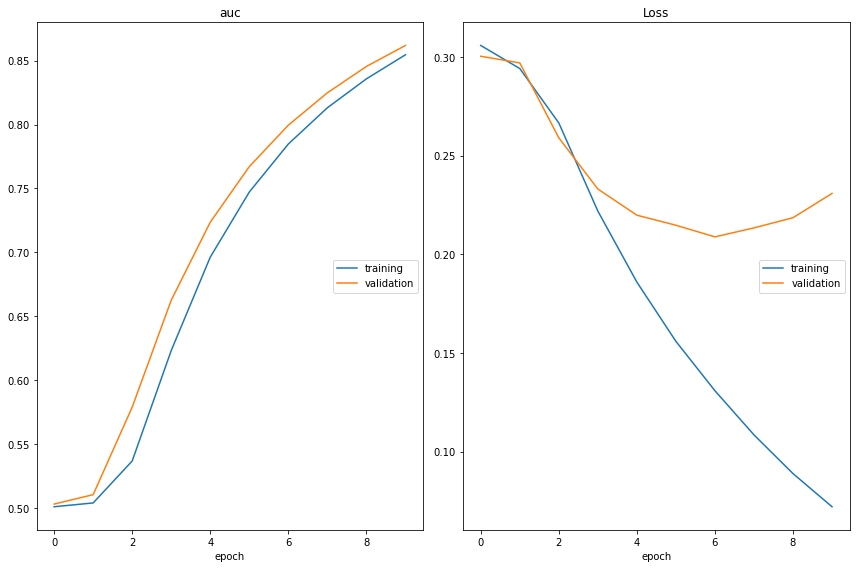

auc
	training         	 (min:    0.501, max:    0.855, cur:    0.855)
	validation       	 (min:    0.503, max:    0.862, cur:    0.862)
Loss
	training         	 (min:    0.072, max:    0.306, cur:    0.072)
	validation       	 (min:    0.209, max:    0.300, cur:    0.231)


In [94]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=128, epochs=10, verbose=1,
          callbacks=[PlotLossesKeras()])

In [100]:
y_pred = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred, average='macro')

0.8846028737772631

### Precit over test dataframe

In [96]:
# Lemmatization
X1_dtm = vect.fit_transform(X1)
X1_pad=X1_dtm.toarray()
X1_pad

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [5, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [97]:
print(vect.inverse_transform(X1_dtm[0]))
print(X1.tolist()[0])

[array(['meet', 'fate', 'shall', 'seal', 'osborn', 'run', 'along', 'beach',
       'stumbl', 'upon', 'bottl', 'wash', 'shore', 'insid', 'messag',
       'read', 'letter', 'feel', 'move', 'yet', 'felt', 'violat',
       'someon', 'thought', 'love', 'man', 'never', 'met', 'track',
       'author', 'small', 'town', 'two', 'lover', 'cross', 'path', 'one',
       'let', 'go', 'past'], dtype='<U16')]
who meets by fate   shall be sealed by fate   theresa osborne is running along the beach when she stumbles upon a bottle washed up on the shore   inside is a message   reading the letter she feels so moved and yet she felt as if she has violated someone  s thoughts   in love with a man she has never met   theresa tracks down the author of the letter to a small town in wilmington   two lovers with crossed paths   but yet one can  t let go of their past 


In [102]:
# Predict over df_test

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_m0=model.predict_proba(X1_pad)
y_pred_m0=pd.DataFrame(y_pred_m0, index=df_test.index, columns=cols)

In [103]:
# Export
y_pred_m0.to_csv('pred_genres_text_NN-3.csv', index_label='ID')